In [46]:
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import json
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import string
import spacy
import transformers
from transformers import pipeline

In [47]:
# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
def json_to_dataframe(json_path):
    data = []
    with open(json_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in line: {line.strip()}")
                print(f"Error message: {e}")
                continue

    return pd.DataFrame(data)

In [49]:
business_path = "Yelp JSON/yelp_dataset/yelp_academic_dataset_business.json"

df_businesses = json_to_dataframe(business_path)

print(f"Total businesses in the dataset: {len(df_businesses)}")

Total businesses in the dataset: 150346


In [50]:
review_path = "Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json"

df_reviews = json_to_dataframe(review_path)
print(f"Total reviews in the dataset: {len(df_reviews)}")

Total reviews in the dataset: 6990280


In [51]:
user_path = "Yelp JSON/yelp_dataset/yelp_academic_dataset_user.json"

df_user = json_to_dataframe(user_path)
print(f"Total users in the dataset: {len(df_user)}")

Total users in the dataset: 1987897


### Different Type of Businesses and their Count

<Axes: >

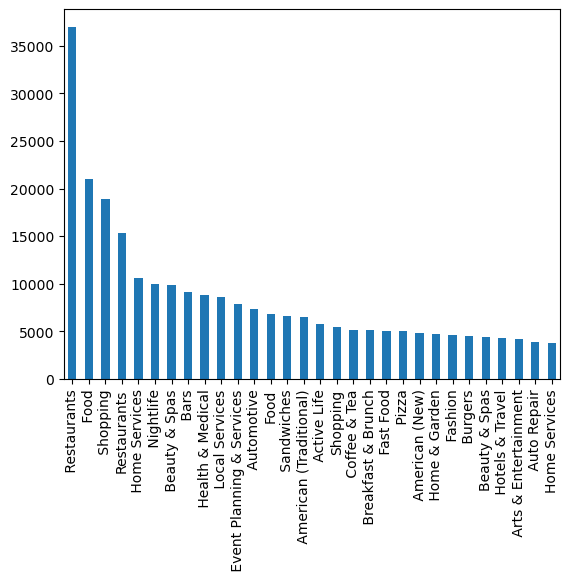

In [52]:
uniq_cat_dict = {}
for i in df_businesses['categories']:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

In [53]:
city_counts = df_businesses['city'].value_counts()

print(f"Total unique cities: {len(city_counts)}")

print("\nTop 15 cities with the most businesses:")
for city, count in city_counts.head(15).items():
    print(f"{city}: {count}")

Total unique cities: 1416

Top 15 cities with the most businesses:
Philadelphia: 14569
Tucson: 9250
Tampa: 9050
Indianapolis: 7540
Nashville: 6971
New Orleans: 6209
Reno: 5935
Edmonton: 5054
Saint Louis: 4827
Santa Barbara: 3829
Boise: 2937
Clearwater: 2221
Saint Petersburg: 1663
Metairie: 1643
Sparks: 1624


### We decided to work with restaurants in the city of Sparks

In [54]:
df_restaurants_sparks = df_businesses[df_businesses['city'] == 'Sparks']
df_restaurants_sparks = df_restaurants_sparks[df_restaurants_sparks['categories'].str.contains('Restaurants', na=False)]
df_restaurants_sparks = df_restaurants_sparks.reset_index(drop=True)

df_restaurants_sparks = df_restaurants_sparks[df_restaurants_sparks['business_id'].isin(df_reviews['business_id'])]
df_restaurants_sparks = df_restaurants_sparks.reset_index(drop=True)

In [55]:
df_reviews_sparks = df_reviews[df_reviews['business_id'].isin(df_restaurants_sparks[df_restaurants_sparks['city'] == 'Sparks']['business_id'])]
df_reviews_sparks = df_reviews_sparks.reset_index(drop=True)

## DATA EXPLORATORY ANALISIS 

In [56]:
df_restaurants_sparks.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Lx8ZYUJ_-3Aa8N821mN1WQ,ALM Kainan,"390 N McCarran Blvd, Ste B",Sparks,NV,89434,39.537179,-119.735532,4.0,13,0,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'F...","Restaurants, Filipino","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
1,UX3eq0WsVva-cqlVrzyzFg,Cantina Los Tres Hombres,926 Victorian Ave,Sparks,NV,89431,39.535111,-119.754857,3.0,284,1,"{'HasTV': 'True', 'RestaurantsPriceRange2': '2...","Bars, Nightlife, Mexican, Restaurants, Seafood","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
2,YhQAQhG1IkXJH7oLZMbM9w,Del Taco,252 Los Altos Pkwy,Sparks,NV,89431,39.583653,-119.740935,1.5,60,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Restaurants, Fast Food, Mexican","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,qbPsfIKJZQAlrPaYmSyZuQ,All Wrapped Up,,Sparks,NV,89431,39.540154,-119.748395,4.0,7,1,"{'RestaurantsDelivery': 'False', 'GoodForMeal'...","Food Trucks, Food, Salad, Sandwiches, Caterers...",None
4,V4THIJk9uhoxL7f06fK5VA,Roundabout Catering,631 Dunn Cir,Sparks,NV,89431,39.528286,-119.734864,5.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Caterers, Party Equipment Rentals, Food, Venue...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


In [57]:
df_restaurants_sparks.describe()

,latitude,longitude,stars,review_count,is_open
count,334.000000,334.000000,334.000000,334.000000,334.000000
mean,39.550736,-119.736836,3.407186,114.386228,0.718563
std,0.025439,0.025591,0.821306,156.482786,0.450375
min,39.520643,-119.813527,1.500000,5.000000,0.000000
25%,39.534481,-119.753786,3.000000,25.250000,0.000000
50%,39.541638,-119.738714,3.500000,60.000000,1.000000
75%,39.556945,-119.719900,4.000000,133.750000,1.000000
max,39.640527,-119.556307,5.000000,1576.000000,1.000000


In [58]:
df_restaurants_sparks.shape

(334, 14)

In [59]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [60]:
df_reviews_sparks.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [61]:
df_reviews_sparks.shape

(40186, 9)

In [62]:
df_reviews_sparks.describe()

,stars,useful,funny,cool
count,40186.000000,40186.000000,40186.000000,40186.000000
mean,3.594038,1.277709,0.306574,0.691086
std,1.542312,2.868504,1.315701,2.242514
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,217.000000,103.000000,201.000000


In [63]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [64]:
df_user.shape

(1987897, 22)

In [65]:
df_user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06
mean,2.339441e+01,4.229634e+01,1.697054e+01,2.379291e+01,1.465740e+00,3.630494e+00,1.807072e+00,2.922631e-01,1.793176e-01,1.336493e-01,6.390723e-02,1.443135e+00,3.011841e+00,2.829308e+00,2.829308e+00,1.056448e+00,1.226859e+00
std,8.256699e+01,6.414806e+02,4.078034e+02,5.653513e+02,1.813075e+01,1.183337e+00,7.360184e+01,1.282467e+01,1.515525e+01,1.135682e+01,1.004363e+01,6.016790e+01,1.193898e+02,9.666385e+01,9.666385e+01,3.217973e+01,9.515751e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.880000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.700000e+01,1.300000e+01,2.000000e+00,3.000000e+00,0.000000e+00,4.560000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.747300e+04,2.062960e+05,1.858230e+05,1.998780e+05,1.249700e+04,5.000000e+00,2.578400e+04,1.350100e+04,1.418000e+04,1.365400e+04,1.266900e+04,5.903100e+04,1.010970e+05,4.996700e+04,4.996700e+04,1.593400e+04,8.263000e+04


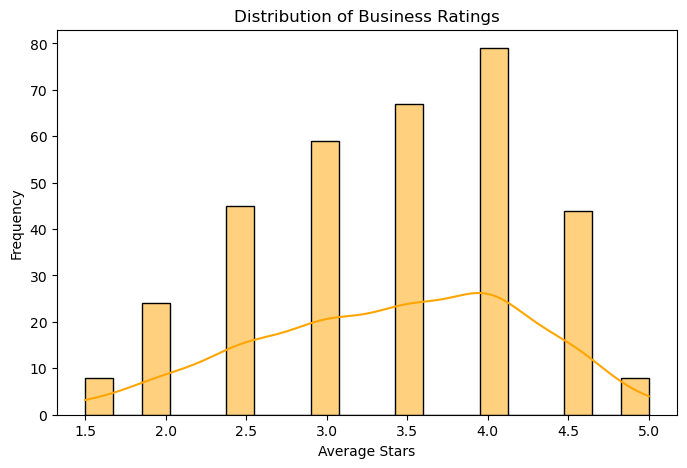

In [66]:
plt.figure(figsize=(8, 5))
sns.histplot(df_restaurants_sparks['stars'], bins=20, kde=True, color="orange")
plt.title("Distribution of Business Ratings")
plt.xlabel("Average Stars")
plt.ylabel("Frequency")
plt.show()


/var/folders/5y/9y4bbwk912b2n780xy4ct7jr0000gn/T/ipykernel_15805/754868800.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")


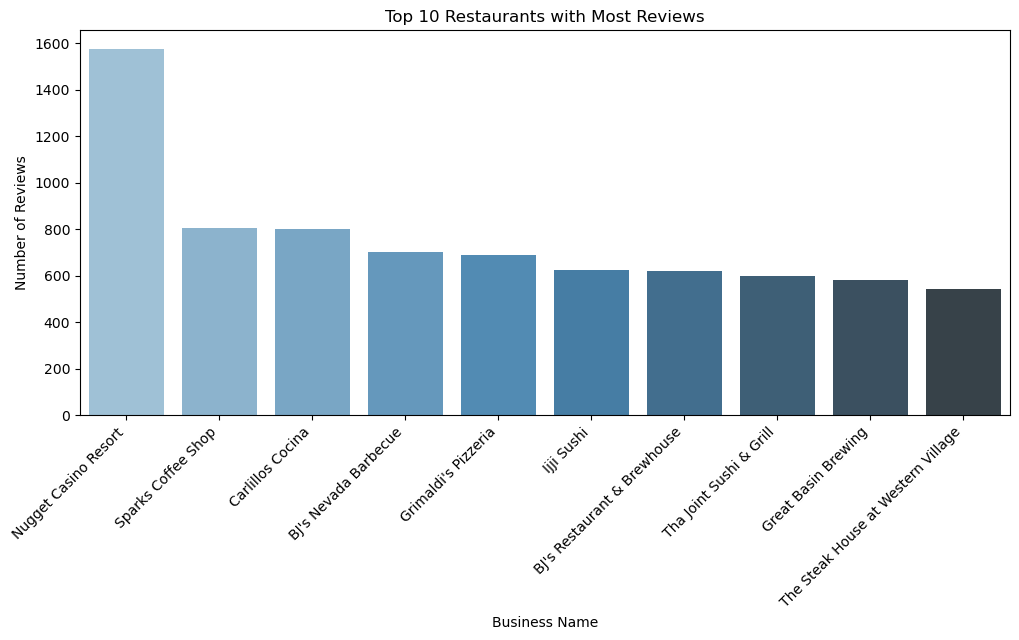

In [67]:
top_business = df_restaurants_sparks.nlargest(10, 'review_count')

plt.figure(figsize=(12, 5))
sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Restaurants with Most Reviews")
plt.xlabel("Business Name")
plt.ylabel("Number of Reviews")
plt.show()


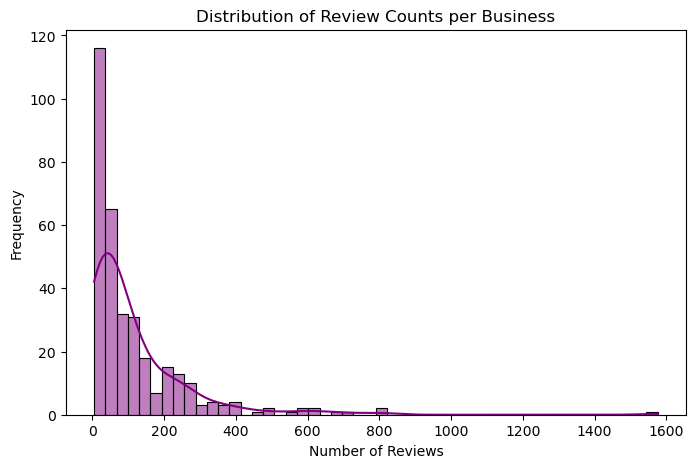

In [68]:
plt.figure(figsize=(8, 5))
sns.histplot(df_restaurants_sparks['review_count'], bins=50, kde=True, color="purple")
plt.title("Distribution of Review Counts per Business")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
#plt.xscale("log") 
plt.show()


/var/folders/5y/9y4bbwk912b2n780xy4ct7jr0000gn/T/ipykernel_15805/2440350942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x="Category", y="Count", palette="coolwarm")


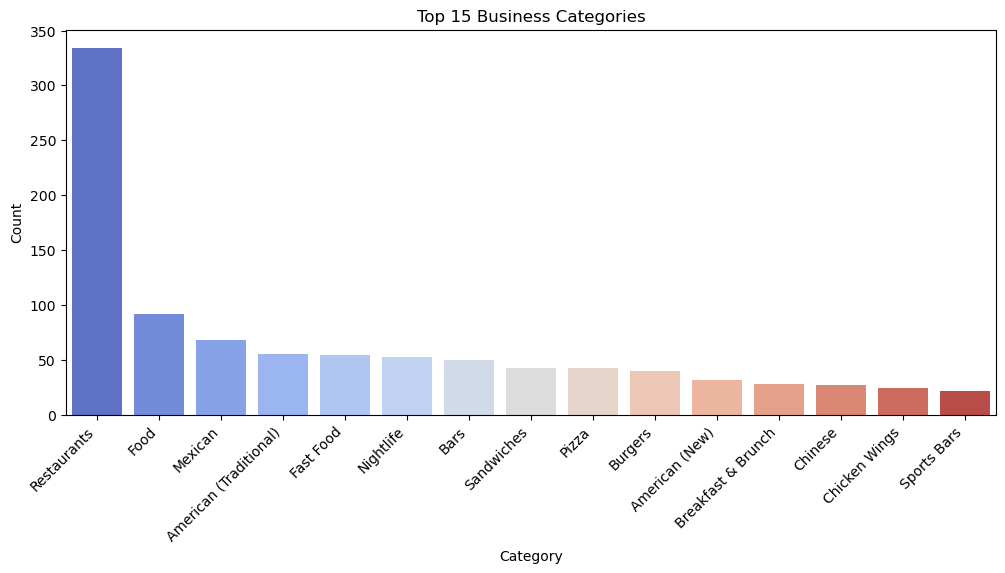

In [69]:

categories = df_restaurants_sparks['categories'].dropna().str.split(', ').explode()
top_categories = pd.DataFrame(Counter(categories).most_common(15), columns=['Category', 'Count'])

plt.figure(figsize=(12, 5))
sns.barplot(data=top_categories, x="Category", y="Count", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Business Categories")
plt.show()


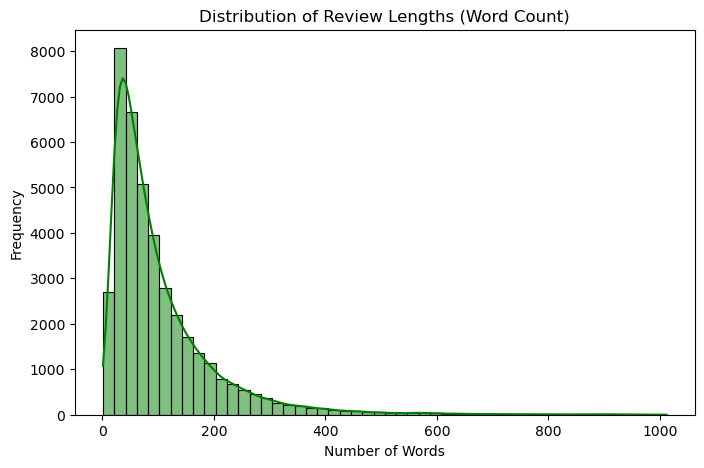

In [70]:
df_reviews_sparks["review_length"] = df_reviews_sparks["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df_reviews_sparks["review_length"], bins=50, kde=True, color="green")
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


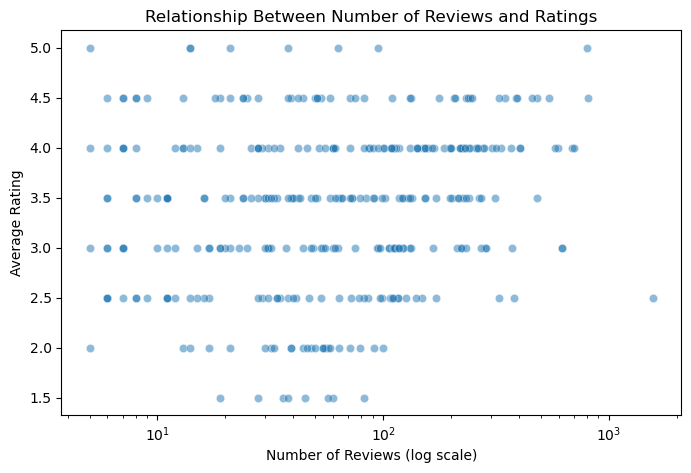

In [71]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_restaurants_sparks, x="review_count", y="stars", alpha=0.5)
plt.xscale("log")  # Log scale for better visualization
plt.title("Relationship Between Number of Reviews and Ratings")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Average Rating")
plt.show()


/var/folders/5y/9y4bbwk912b2n780xy4ct7jr0000gn/T/ipykernel_15805/2890383428.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")


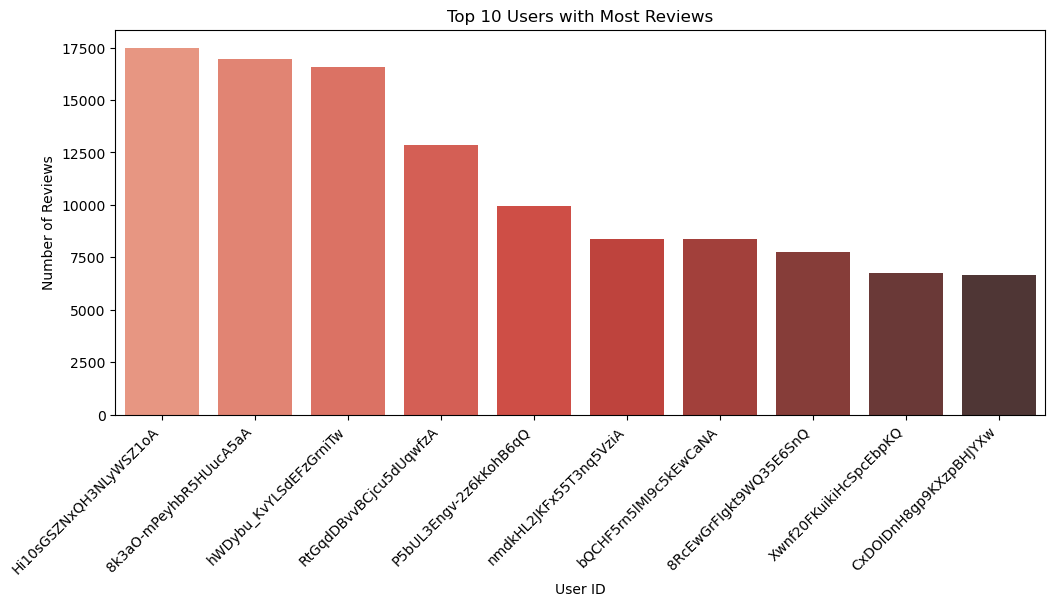

In [72]:
top_users = df_user.nlargest(10, "review_count")

plt.figure(figsize=(12, 5))
sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Users with Most Reviews")
plt.xlabel("User ID")
plt.ylabel("Number of Reviews")
plt.show()


/var/folders/5y/9y4bbwk912b2n780xy4ct7jr0000gn/T/ipykernel_15805/1214369400.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_reviews_sparks, x="sentiment", palette="Set1")


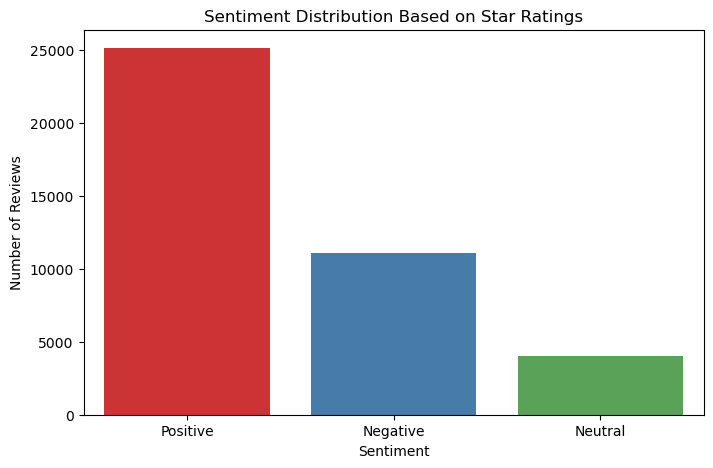

In [73]:
df_reviews_sparks["sentiment"] = df_reviews_sparks["stars"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

plt.figure(figsize=(8, 5))
sns.countplot(data=df_reviews_sparks, x="sentiment", palette="Set1")
plt.title("Sentiment Distribution Based on Star Ratings")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


/var/folders/5y/9y4bbwk912b2n780xy4ct7jr0000gn/T/ipykernel_15805/1774630989.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_categories, x="stars", y="categories", palette="viridis")


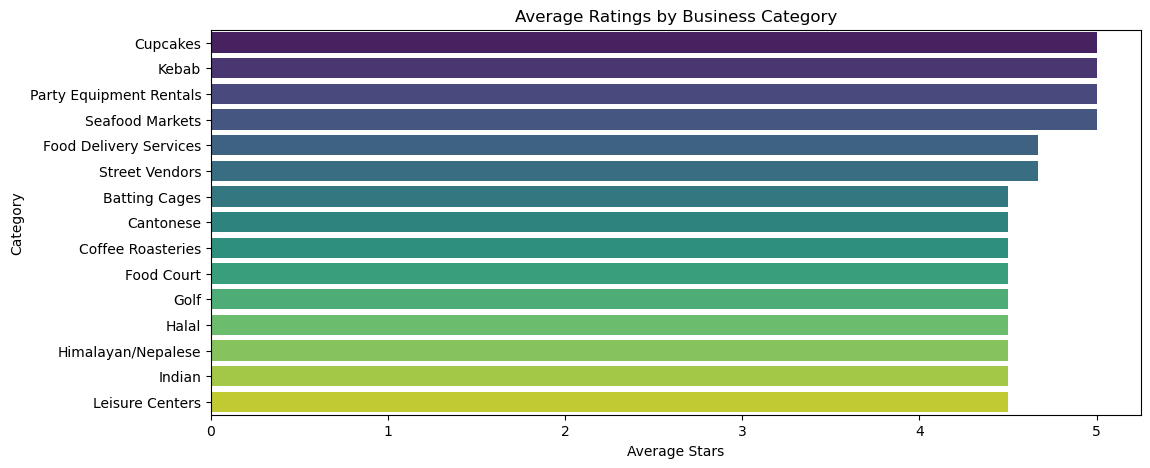

In [74]:
df_categories = df_restaurants_sparks[['categories', 'stars']].dropna()
df_categories = df_categories.assign(categories=df_categories['categories'].str.split(', ')).explode('categories')
df_categories = df_categories.groupby('categories')['stars'].mean().reset_index()
df_categories = df_categories.nlargest(15, 'stars')

plt.figure(figsize=(12, 5))
sns.barplot(data=df_categories, x="stars", y="categories", palette="viridis")
plt.title("Average Ratings by Business Category")
plt.xlabel("Average Stars")
plt.ylabel("Category")
plt.show()


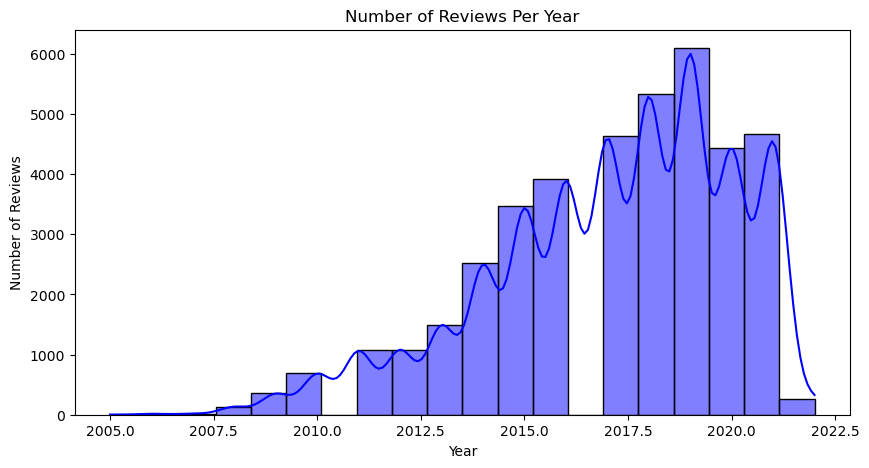

In [75]:
df_reviews_sparks["year"] = pd.to_datetime(df_reviews_sparks["date"]).dt.year

plt.figure(figsize=(10, 5))
sns.histplot(df_reviews_sparks["year"], bins=20, kde=True, color="blue")
plt.title("Number of Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()


## Natural Language Processing

In [76]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


def preprocess_text(text):
    text = text.lower().strip()  # Lowercase e remover espaços extras

    # Remover caracteres especiais, mas manter números
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    # Tokenização, remoção de stopwords e lematização
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return " ".join(tokens)

In [77]:
tqdm.pandas(desc="Processing texts")
df_reviews_sparks["clean_text"] = df_reviews_sparks["text"].progress_apply(preprocess_text)
print("\nTexts processed!\n")

Processing texts: 100%|██████████| 40186/40186 [03:58<00:00, 168.15it/s]


Texts processed!



### Hybrid Recommender System (Content-Based and Collaborative Filtering)

#### Content-based
* Sentiment Analysis

In [78]:
! python -m nltk.downloader vader_lexicon

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [79]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df_reviews_sparks['sentiment'] = df_reviews_sparks['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_reviews_sparks.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length,sentiment,year,clean_text
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,83,0.9510,2009,good pizza hand downlove peep run place hock...
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,57,0.7207,2014,not like sandwich get get jalapeo cheese bread...
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,127,0.9908,2016,come reno yellow sub ask sprout sub will not r...
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,49,0.9758,2013,yummy food veganize thing server friendly re...
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,24,0.9165,2010,new baconbleu cheeseburger excellent probably ...


### Build Content-Based Filtering

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

reviews_agg = df_reviews_sparks.groupby('business_id')['text'].apply(' '.join).reset_index()

restaurantes_sparks = df_restaurants_sparks.merge(reviews_agg, on='business_id', how='left')
restaurantes_sparks['texto_completo'] = restaurantes_sparks['categories'] + " " + restaurantes_sparks['text'].fillna("")

tfidf = TfidfVectorizer(max_features=300, ngram_range=(1,2))  # Limita a 1000 palavras mais relevantes
tfidf_matrix = tfidf.fit_transform(restaurantes_sparks['texto_completo'])

content_sim = cosine_similarity(tfidf_matrix)

### Build Collaborative Filtering

In [91]:
from surprise import SVD, Dataset, Reader

# Ajustar estrelas com sentimento (ex.: stars * (1 + sentiment))
# df_reviews_sparks['adjusted_stars'] = df_reviews_sparks['stars'] * (1 + df_reviews_sparks['sentiment'])
df_reviews_sparks['adjusted_stars'] = df_reviews_sparks['stars'] * (1 + 0.5 * df_reviews_sparks['sentiment'])
df_reviews_sparks['adjusted_stars'] = df_reviews_sparks['adjusted_stars'].clip(1, 5)  # Mantém entre 1 e 5

# Preparar dados para o Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_reviews_sparks[['user_id', 'business_id', 'adjusted_stars']], reader)
trainset = data.build_full_trainset()

algo = SVD()
algo.fit(trainset)

In [92]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


### Combine

In [93]:
def recomendar_hibrido(user_id, n=5):
    # Previsões do Collaborative Filtering
    collab_preds = [(bid, algo.predict(user_id, bid).est) for bid in restaurantes_sparks['business_id']]
    collab_df = pd.DataFrame(collab_preds, columns=['business_id', 'collab_score'])

    # Previsões do Content-Based - Encontrar o restaurante mais bem avaliado pelo usuário
    user_top = df_reviews_sparks[df_reviews_sparks['user_id'] == user_id].sort_values('stars', ascending=False)
    if not user_top.empty:
        top_bid = user_top.iloc[0]['business_id']
        top_idx = restaurantes_sparks.index[restaurantes_sparks['business_id'] == top_bid][0]
        content_scores = pd.DataFrame({
            'business_id': restaurantes_sparks['business_id'],
            'content_score': content_sim[top_idx]
        })
    else:
        # User novo: usar média de sentimento
        content_scores = df_reviews_sparks.groupby('business_id')['sentiment'].mean().reset_index()
        content_scores.columns = ['business_id', 'content_score']

    combined = collab_df.merge(content_scores, on='business_id')
    combined['final_score'] = 0.6 * combined['collab_score'] + 0.4 * combined['content_score']

    top_n = combined.sort_values('final_score', ascending=False).head(n)
    return top_n.merge(restaurantes_sparks[['business_id', 'name']], on='business_id')

usuario = 'hA5lMy-EnncsH4JoR-hFGQ'  
recomendacoes = recomendar_hibrido(usuario)
recomendacoes

,business_id,collab_score,content_score,final_score,name
0,8QqnRpM-QxGsjDNuu0E57A,4.877423,0.852795,3.267572,Carlillos Cocina
1,TqezXFPh-f2cqIgkMvzHmQ,4.783287,0.886980,3.224764,Sierra Gold Seafood
2,hjRxa6xpKOwnbUgGvVCE5Q,4.784123,0.863473,3.215863,Sparks Coffee Shop
3,iwVYwD_5u-JCyplAw9bhfg,4.760674,0.850897,3.196763,Sparks and Smoke BBQ
4,3I-jEV_Iuz_tFpgCqL3sGw,4.745269,0.869473,3.194951,Daddy's Tacos NV


### Evaluation

In [94]:
from sklearn.model_selection import train_test_split

# Dividir os dados
df_reviews_sparks_train, df_reviews_sparks_test = train_test_split(df_reviews_sparks, test_size=0.2, random_state=42)

In [95]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

# Preparar dados pro Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_reviews_sparks_train[['user_id', 'business_id', 'adjusted_stars']], reader)
trainset, testset = surprise_split(data, test_size=0.2)

# Treinar o modelo
algo = SVD()
algo.fit(trainset)

# Prever e calcular RMSE
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.3789


In [96]:
def precision_recall_at_k(user_id, k=5):
    # Recomendações do sistema híbrido
    recomendados = recomendar_hibrido(user_id, k)
    recomendados_ids = set(recomendados['business_id'])
    
    # Revisões reais do usuário no conjunto de teste
    user_test = df_reviews_sparks_test[df_reviews_sparks_test['user_id'] == user_id]
    gostados = set(user_test[user_test['stars'] >= 4]['business_id'])
    
    # Calcular precisão e recall
    relevantes = recomendados_ids.intersection(gostados)
    precision = len(relevantes) / k if k > 0 else 0
    recall = len(relevantes) / len(gostados) if len(gostados) > 0 else 0
    return precision, recall

# Testar para alguns usuários
users = df_reviews_sparks_test['user_id'].unique()[:10]  # 10 usuários pra exemplo
precisions, recalls = [], []
for user in users:
    p, r = precision_recall_at_k(user)
    precisions.append(p)
    recalls.append(r)

print(f"Precision@5 média: {sum(precisions)/len(precisions):.2f}")
print(f"Recall@5 média: {sum(recalls)/len(recalls):.2f}")

Precision@5 média: 0.06
Recall@5 média: 0.25


### Deep sentiment analysis using Hybrid Aprroach *(Sentiment CLassification(positive, neural, negativa))* and *(Emotion Detection (joy, sadness, anger, etc))*

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline

from sentence_transformers import SentenceTransformer, util
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Sentiment Analysis with  custom model, spliting the data in chunks to avoid memory issues

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch

def generate_embeddings_and_sentiment(df_reviews):
    """Gera embeddings e sentimentos (0-1) em uma única passada"""
    # Carregar modelos
    embed_model = SentenceTransformer('all-MiniLM-L6-v2')
    sentiment_pipe = pipeline(
        'text-classification',
        model='distilbert-base-uncased-finetuned-sst-2-english',
        return_all_scores=False  # Retorna apenas o label dominante e score
    )
    
    # Gerar embeddings e sentimentos
    tqdm.pandas(desc="Processando textos")
    df_reviews['embedding'] = df_review['clean_text'].progress_apply(
        lambda x: embed_model.encode(x, convert_to_tensor=True)
    )
    
    df_review['sentiment_score'] = df_review['clean_text'].progress_apply(
        lambda x: sentiment_pipe(x[:512])[0]['score'] if x else 0.5
    )
    
    return df_review


In [ ]:
df_review = generate_embeddings_and_sentiment(df_review)
df_review.head()

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
/home/longras/anaconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Processando textos: 100%|██████████| 40186/40186 [03:38<00:00, 183.51it/s]


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length,sentiment,year,clean_text,embedding,sentiment_score
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,83,Positive,2009,good pizza hand downlove peep run place hock...,"[tensor(-0.1193, device='cuda:0'), tensor(-0.0...",0.882510
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,57,Negative,2014,not like sandwich get get jalapeo cheese bread...,"[tensor(-0.0569, device='cuda:0'), tensor(0.04...",0.999336
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,127,Positive,2016,come reno yellow sub ask sprout sub will not r...,"[tensor(-0.0889, device='cuda:0'), tensor(-0.0...",0.998586
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,49,Positive,2013,yummy food veganize thing server friendly re...,"[tensor(0.0021, device='cuda:0'), tensor(-0.02...",0.999180
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,24,Positive,2010,new baconbleu cheeseburger excellent probably ...,"[tensor(-0.0663, device='cuda:0'), tensor(0.03...",0.999426


In [ ]:
def recommend_business_v5(target_business_id, topn=5):
    """
    Combina:
    - Similaridade semântica (embeddings)
    - Score de sentimento (0-1)
    """
    # Obter embedding médio do negócio alvo
    target_reviews = df_review[df_review['business_id'] == target_business_id]
    target_embedding = torch.mean(torch.stack(target_reviews['embedding'].tolist()), dim=0)
    
    # Calcular similaridades e filtrar
    df_review['similarity'] = df_review['embedding'].apply(
        lambda x: util.pytorch_cos_sim(target_embedding, x).item()
    )
    
    # Combinar scores (similaridade * sentimento)
    df_review['combined_score'] = df_review['similarity'] * df_review['sentiment_score']
    
    # return df_restaurants filtered by business_id
    recommendations = df_restaurants[df_restaurants['business_id'].isin(df_review['business_id'])]
    recommendations = recommendations.merge(
        df_review.groupby('business_id')['combined_score'].mean(),
        on='business_id'
    )
    recommendations = recommendations.sort_values('combined_score', ascending=False)
    
    
    return recommendations.drop_duplicates('business_id')


In [ ]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length,sentiment,year,clean_text,embedding,sentiment_score,similarity,combined_score
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,83,Positive,2009,good pizza hand downlove peep run place hock...,"[tensor(-0.1193, device='cuda:0'), tensor(-0.0...",0.882510,0.753934,0.665354
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,57,Negative,2014,not like sandwich get get jalapeo cheese bread...,"[tensor(-0.0569, device='cuda:0'), tensor(0.04...",0.999336,0.477865,0.477548
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,127,Positive,2016,come reno yellow sub ask sprout sub will not r...,"[tensor(-0.0889, device='cuda:0'), tensor(-0.0...",0.998586,0.476746,0.476072
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,49,Positive,2013,yummy food veganize thing server friendly re...,"[tensor(0.0021, device='cuda:0'), tensor(-0.02...",0.999180,0.527485,0.527053
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,24,Positive,2010,new baconbleu cheeseburger excellent probably ...,"[tensor(-0.0663, device='cuda:0'), tensor(0.03...",0.999426,0.534449,0.534142


In [ ]:
df_restaurants.sort_values('stars', ascending=False).head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
177,DSYVbqvHETkd_DWvmYxPXQ,The Pizza box,,Sparks,NV,89431,39.540154,-119.748395,5.0,5,1,"{'BusinessParking': '{'garage': False, 'street...","Food Trucks, Restaurants, Food, Street Vendors...","{'Monday': '18:0-22:0', 'Tuesday': '18:0-22:0'..."
216,3I-jEV_Iuz_tFpgCqL3sGw,Daddy's Tacos NV,641 S Rock Blvd,Sparks,NV,89431,39.528180,-119.767010,5.0,63,1,"{'WiFi': 'u'no'', 'BusinessParking': '{'garage...","Restaurants, Mexican, Food, Food Trucks","{'Tuesday': '17:0-21:0', 'Wednesday': '17:0-21..."
263,fbFdE_qy_3s3r9h1gxAq0w,Asian Street Eats,,Sparks,NV,89431,39.540154,-119.748395,5.0,14,1,"{'BusinessParking': '{'garage': False, 'street...","Food, Food Trucks, Sandwiches, Restaurants, Kebab",None
38,TqezXFPh-f2cqIgkMvzHmQ,Sierra Gold Seafood,"1335 Greg St, Ste 105",Sparks,NV,89431,39.520810,-119.760232,5.0,95,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Grocery, Specialty Food, Restaurants, Food, Se...","{'Tuesday': '10:0-18:0', 'Wednesday': '10:0-18..."
305,2F9HUYrY0jGDwYzBWO_ljg,Taqueria El Gordo,415 S Rock Blvd,Sparks,NV,89431,39.530163,-119.766298,5.0,14,0,"{'RestaurantsGoodForGroups': 'False', 'Restaur...","Ethnic Food, Mexican, Restaurants, Food, Speci...","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."


In [ ]:
recommend_business_v5("l4aS1QVy_bGnwUXSJzpbsw")

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,combined_score
26,l4aS1QVy_bGnwUXSJzpbsw,Big Apple Pizza & Subs,720 Baring Blvd,Sparks,NV,89434,39.556883,-119.732753,4.0,15,0,"{'GoodForKids': 'True', 'RestaurantsReservatio...","Pizza, Restaurants",None,0.722689
246,E-__CjHyCxppMsq5_S7iMg,Windy City Pizza,2995 Vista Blvd,Sparks,NV,89434,39.557988,-119.705688,4.0,19,0,"{'NoiseLevel': 'u'average'', 'BusinessAcceptsC...","Restaurants, Chicken Wings, Pizza, Salad","{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0.650625
177,DSYVbqvHETkd_DWvmYxPXQ,The Pizza box,,Sparks,NV,89431,39.540154,-119.748395,5.0,5,1,"{'BusinessParking': '{'garage': False, 'street...","Food Trucks, Restaurants, Food, Street Vendors...","{'Monday': '18:0-22:0', 'Tuesday': '18:0-22:0'...",0.650565
59,aWtGUfteN6k3Kbt111q6VQ,True NY Pizza,"2888 Vista Blvd, Ste 102",Sparks,NV,89434,39.556965,-119.703990,4.0,278,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsDe...","Restaurants, Pizza, Italian, Salad","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",0.632211
50,W72rYffSVg0pIaOpRgNniw,Grimaldi's Pizzeria,1180 Scheels Dr,Sparks,NV,89434,39.530954,-119.722774,4.0,689,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Restaurants, Food, Pizza","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",0.618269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,tzSKydKgvXCDp2bzdynoLQ,Starbucks,2858 Vista Blvd,Sparks,NV,89434,39.555764,-119.703808,2.5,7,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Food, Restaurants, Coffee & Tea","{'Monday': '5:30-19:0', 'Tuesday': '5:30-19:0'...",0.391815
186,8oxFSb3azCU1NbZREmb2eg,Subway Restaurants,"1495 E Prater Way, Ste 127, Marina Marketplace...",Sparks,NV,89434,39.541452,-119.716242,1.5,38,1,"{'OutdoorSeating': 'False', 'GoodForKids': 'Tr...","Sandwiches, Fast Food, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",0.387967
217,yBrK-DwpdbJY2F795ZStcw,Starbucks,2835 N McCarren Blvd,Sparks,NV,89431,39.555333,-119.752917,3.0,55,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Food, Restaurants, Coffee & Tea","{'Monday': '4:30-20:0', 'Tuesday': '4:30-20:0'...",0.385809
271,WTrmBvsI65Zk5SvRweNZkw,Starbucks,1550 E Lincoln Way,Sparks,NV,89434,39.535494,-119.716902,2.5,12,1,"{'RestaurantsPriceRange2': '2', 'OutdoorSeatin...","Restaurants, Food, Coffee & Tea","{'Monday': '0:0-0:0', 'Tuesday': '8:0-21:0', '...",0.370808
